# Z P Optimizer

### Alexander Munoz, Emily Simons, Margaux Hujoel

In [180]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mode
import itertools
from z_matrix import create_Z
from simulator import Simulator
from collections import Counter

## Implementation

In [327]:
class Z_P_Optimizer(object):
    ''' 
    Generates a C from standard uniform, then determines corresponding Z and P
    - N is number of loci,
    - M is number of samples,
    - C_num is number of clustered clones
    '''
    
    def __init__(self, loci_num=5, samples_num=5, clones_num=3):
        self.N = loci_num
        self.M = samples_num
        self.C_num = clones_num
    
    def __possible_M_cols_helper(self, clone_num):
        ''' Generate possible M matrix columns '''
        if clone_num == 0:
            return np.array([])
        start = np.array([1 for i in range(clone_num)])
        possibles = [start]
        for i in range(clone_num-1):
            new_possibles = []
            for p in possibles:
                curr_adder = np.array([0 for j in range(i+1)] + \
                                      [1 for j in range(clone_num-(i+1))])
                new_possibles.append(p + curr_adder)
            possibles += new_possibles
        possibles += [np.append(j,0) for j in self.__possible_M_cols_helper(clone_num-1)]
        return possibles

    def __possible_M_cols(self, clone_num, prev_max_index=0):
        ''' Generate possible M matrix columns given previous column's max index '''
        old_possibles = self.__possible_M_cols_helper(clone_num)
        new_possibles = []
        for p in old_possibles:
            adder = np.zeros(clone_num)
            adder[np.nonzero(p)[0]] = prev_max_index
            new_possibles.append(p + adder)
        new_possibles +=  [np.array([0. for j in range(clone_num)])]
        return new_possibles
    
    def __stochastic_Ms_helper(self, empty_clones, prev_max):
        ''' select a stochastic M '''
        if prev_max == self.N or empty_clones == self.C_num:
            return np.zeros((self.C_num, 1))
        curr_poss_cols = self.__possible_M_cols(self.C_num-empty_clones, prev_max)
        looping = True
        while looping:
            random_col_truncated = curr_poss_cols[np.random.choice(len(curr_poss_cols))]
            random_col = np.concatenate((random_col_truncated, np.zeros(empty_clones)))
            if max(random_col) <= self.N:
                looping = False
        zero_inds = np.where(random_col==0)[0]
        if len(zero_inds > 0):
            new_empties = self.C_num - min(zero_inds)
        else:
            new_empties = 0
        return np.column_stack((random_col, \
                                self.__stochastic_Ms_helper(empty_clones=new_empties, prev_max=max(random_col))))
    
    def __validate_M(self, M_org):
        ''' Reorder an M for common mutations on left, then check for perfect phylogency (mutations arise once)'''
        M_new = M_org
        curr_swap_col = 0
        for row_count in range(M_org.shape[0]): #first swap columns for most common mutations on left
            for col_num in range(M_org.shape[1]):
                curr_col = M_new[:,col_num]
                if row_count == 0 and len(set(curr_col)) == 1 and curr_col[0] != 0:
                    M_new[:,[curr_swap_col, col_num]] = M_new[:,[col_num, curr_swap_col]]
                    curr_swap_col += 1
                elif row_count > 0 and set(curr_col[-1*row_count:]) == {0} \
                                   and len(set(curr_col[:-1*row_count])) == 1 and curr_col[0] != 0:
                    M_new[:,[curr_swap_col, col_num]] = M_new[:,[col_num, curr_swap_col]]
                    curr_swap_col += 1
        curr_swap = 1 #order feature enumeration by mutation count
        for search_req in np.arange(2,M_org.shape[0]+1,1)[::-1]:
            for col_num in range(M_org.shape[1]):
                for p in Counter([a for a in M_new[:,col_num] if a!=0]).most_common():
                    if p[0] in np.arange(1,curr_swap,1):
                        pass
                    elif p[1] == search_req and p[0] == curr_swap:
                        curr_swap += 1
                    elif p[1] == search_req and p[0] != curr_swap:
                        for col_num_adj in range(M_org.shape[1]):
                            olds = np.where(M_new[:,col_num_adj]==curr_swap)[0]
                            if olds.size != 0:
                                M_new[:,col_num_adj] = [p[0] if a==curr_swap else a for a in M_new[:,col_num_adj]]
                                break
                        M_new[:,col_num] = [curr_swap if a==p[0] else a for a in M_new[:,col_num]]
                        curr_swap += 1
        for row_num in range(M_org.shape[0]): #then sort by feature number & shift zeros to the right of a given row
            curr_row = M_new[row_num, :]
            new_row = np.concatenate((np.sort(curr_row[curr_row!=0]), curr_row[curr_row==0]))
            M_new[row_num, :] = new_row
        possible_vals = set(np.arange(np.amax(M_tst_new))+1) #now validate each number appears in only one column
        for col_num in range(M_org.shape[1]):
            curr_col = set(M_new[:,col_num])-{0}
            if curr_col.issubset(possible_vals):
                possible_vals = possible_vals - curr_col
            else:
                return (False, M_new)
        return (True, M_new)

    def __stochastic_Ms(self, Ms_count):
        ''' select multiple stochastic Ms '''
        Ms = []
        for i in range(Ms_count):
            unordered_M = self.__stochastic_Ms_helper(empty_clones=0, prev_max=0)
            b, ordered_M = self.__validate_M(M_org = unordered_M)
            if b:
                Ms.append(ordered_M)
        return Ms
    
    def __stochastic_Zs(self, Zs_count):
        ''' generate multiple stochastic Ms then the corresponding Zs '''
        stochastic_Ms = self.__stochastic_Ms(Ms_count=Zs_count)
        stochastic_Zs = []
        for stochastic_M in stochastic_Ms:
            stochastic_Z = np.zeros((self.N, self.C_num))
            for curr_clone_num in range(self.C_num):
                m_row = stochastic_M[curr_clone_num, :]
                called_indices = [a-1 for a in m_row.astype('int')]
                called_indices = list(filter(lambda x: x >= 0, called_indices))
                stochastic_Z[called_indices, curr_clone_num] = 1
            stochastic_Zs.append(stochastic_Z)
        return stochastic_Zs
    
    def __draw_C_matrix(self, print_bool=False):
        ''' Draw a C matrix from standard uniform given dimensions '''
        C_matrix = np.zeros((self.N, self.M))
        for row in range(self.N):
            for col in range(self.M):
                C_matrix[row][col] = np.random.uniform()
        if print_bool:
            print(C_matrix)
        return C_matrix
    
    def draw_P_matrix(self, print_bool=False):
        ''' Draw a valid P matrix from standard uniform by forcing columns to sum to 1 '''
        P_matrix = np.zeros((self.C_num, self.M))
        for col_idx in range(self.M):
            curr_col = np.array([np.random.uniform() for j in range(self.C_num)])
            P_matrix[:,col_idx] = curr_col / np.sum(curr_col)
        if print_bool:
            print(P_matrix)
        return P_matrix
    
    def __scale_P(self, P_in, print_bool=False):
        ''' Create a valid P matrix by dropping negative probabilities and forcing columns to sum to 1 '''
        P_out = np.zeros((self.C_num, self.M))
        for col_num in range(self.M):
            curr_col = P_in[:,col_num]
            dropped_negs = [c if c>0 else 0 for c in curr_col]
            if np.sum(dropped_negs) != 0:
                scaled = dropped_negs / np.sum(dropped_negs)
            else:
                scaled = dropped_negs
            P_out[:,col_num] = scaled
        if print_bool:
            print(P_out)
        return P_out
    
    def __generate_Zs_Ps_error(self, Zs_count=1000, C_in=None):
        ''' Generate corresponding P matrices from Z and C
            Returns Zs, valid Ps, and sum of residuals (squared Euclidean 2-norm) '''
        if C_in is None:
            C_matrix = self.__draw_C_matrix()
        else:
            C_matrix = C_in
        possible_Zs = self.__stochastic_Zs(Zs_count=Zs_count)
        possible_Ps = []
        errors = []
        for possible_Z in possible_Zs:
            curr_P_solved = np.linalg.lstsq(possible_Z, C_matrix)
            curr_P_scaled = self.__scale_P(curr_P_solved[0])
            curr_resids = (C_matrix - np.dot(possible_Z, curr_P_scaled))**2
            curr_error = np.sum(np.sum(curr_resids))
            possible_Ps.append(curr_P_scaled)
            errors.append(curr_error)
        return (possible_Zs, possible_Ps, errors)
        
    def optimal_Z_P(self, C_in=None, Zs_count=1000, return_dict=False, print_bool=False):
        ''' Generate optimal Z and P given a generated C, or pass in C as input '''
        if C_in is None:
            C_matrix = self.__draw_C_matrix()
        else:
            C_matrix = C_in
        Zs, Ps, errs = self.__generate_Zs_Ps_error(C_in=C_in, Zs_count=Zs_count)
        min_index = np.argmin(errs)
        optimals = Zs[min_index], Ps[min_index], errs[min_index]
        if print_bool:
            print('Input C:')
            for row in C_matrix:
                print(row)
            print()
            print('Optimal Z:')
            for row in Zs[min_index]:
                print(row)
            print()
            print('Optimal P:')
            for row in Ps[min_index]:
                print(row)
            print()
            print('Error:')
            print(errs[min_index])
        if return_dict:
            return {'optimals':optimals , 'Zs':Zs, 'errors':errs}
        else:
            return optimals
    
    def plot_errors(self, C_in=None, Zs_count=1000):
        ''' Plot error graph (x-axis is enumerated Z, y-axis is sum of residuals) '''
        Zs, Ps, errs = self.__generate_Zs_Ps_error(C_in=C_in, Zs_count=Zs_count)
        plt.figure()
        plt.plot(errs)
        plt.title('Sum of Squared Euclidean 2-Norms Vs Enumerated Z')
        plt.xlabel('Enumerated Z index')
        plt.ylabel('Sum of Residuals')
        plt.show()


## Gerlinger Data and Confirmation of Methodology

In [460]:
Gerlinger_data = pd.read_csv('Data/Gerlinger.csv')
loci = [0,1,2,4,6]
Gerlinger_Z = Gerlinger_data.ix[loci,[3,6,7,9]]
opt = Z_P_Optimizer(loci_num=len(loci), samples_num=3, clones_num=4)
P = opt.draw_P_matrix()
C = np.dot(Gerlinger_Z, P)
print('Loci genotyped:', list(Gerlinger_data.ix[loci,1]))
Gerlinger_Z

Loci genotyped: ['PBRM1', 'VHL', 'PTENsplice', 'PTENmis', 'TP53']


,R3,R7,R1,M
0,1,1,1,1
1,1,1,1,1
2,1,0,0,0
4,0,1,0,0
6,0,0,0,1


In [449]:
opt_z, opt_p, opt_err = opt.optimal_Z_P(C_in=C, Zs_count=5000)
opt_z

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.]])

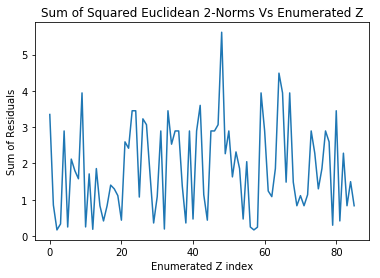

In [74]:
opt.plot_errors(C_in=C, Zs_count=100)

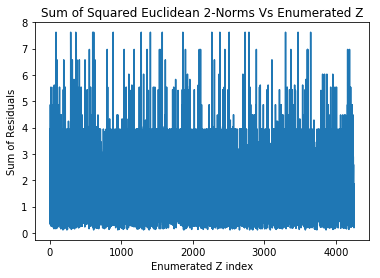

In [75]:
opt.plot_errors(C_in=C, Zs_count=5000)

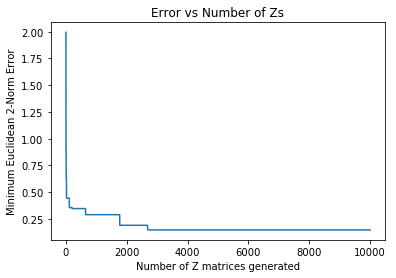

In [155]:
errors = []
for i in range(10000):
    z_opt, p_opt, err_opt = opt.optimal_Z_P(Zs_count=1)
    if len(errors) > 0:
        errors.append(min([err_opt, errors[-1]]))
    else:
        errors.append(err_opt)
plt.figure()
plt.plot(errors)
plt.xlabel('Number of Z matrices generated')
plt.ylabel('Minimum Euclidean 2-Norm Error')
plt.title('Error vs Number of Zs')
plt.show()

In [320]:
errors = []
clone_range = np.arange(2,11,1)
for clone_count in clone_range:
    opt = Z_P_Optimizer(loci_num=5, samples_num=3, clones_num=clone_count)
    z_opt, p_opt, err_opt = opt.optimal_Z_P(C_in=C, Zs_count=5000)
    errors.append(err_opt)
    print(clone_count, end=", ")
print("done.")

2, 3, 4, 5, 6, 7, 8, 9, 10, done.


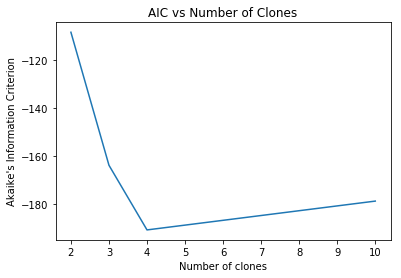

In [322]:
plt.figure()
aic = 100*np.log(np.array(errors))+2*clone_range
plt.plot(clone_range, aic)
plt.ylabel('Akaike\'s Information Criterion')
plt.xlabel('Number of clones')
plt.title('AIC vs Number of Clones')
plt.show()

## Another Example

In [303]:
Z = np.array([[1,0,0],[0,1,1],[0,1,0],[0,0,1]])
opt = Z_P_Optimizer(loci_num=4, samples_num=3, clones_num=3)
P = opt.draw_P_matrix()
C = np.dot(Z, P)
print(Z)

[[1 0 0]
 [0 1 1]
 [0 1 0]
 [0 0 1]]


In [304]:
opt_z, opt_p, opt_err = opt.optimal_Z_P(C_in=C, Zs_count=5000)
opt_z

array([[ 1.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.]])

## Top Zs

In [462]:
return_dict = opt.optimal_Z_P(C_in=C, Zs_count=5000, return_dict=True)
set_Zs, set_idx = np.unique([np.array_str(a) for a in return_dict['Zs']], return_index=True)
top_errs = np.argsort(np.array(return_dict['errors'])[set_idx])[:5]
for Z_curr in set_Zs[top_errs]:
    print(Z_curr)
    print('\n')

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 1.  0.  0.  0.]]


[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  0.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]]


[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 0.  1.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  0.]]


[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]]


[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 0.  0.  1.  1.]
 [ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]]


